# Autoria

* Cristiano Sampaio Pinheiro, RA 256352
* Jhonatan Cléto, RA 256444
* Mylena Roberta dos Santos, RA 222687

# Bibliotecas e Paths

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/MC936/P4/'
PATH_DATA = PATH + 'data/'
PATH_TRAIN = PATH_DATA + 'Train/'
PATH_LES = PATH_DATA + 'LES/'
PATH_ASSETS = PATH + 'assets/'

# Funções para Obtenção das Listas de Imagens

In [4]:
def get_mask_area(mask_list: list) -> np.array:
  """
    ## Descrição:
     - Computa a quantidade de pixels ocupados pela máscara
     em cada imagem no conjunto fornecido

    ## Entrada:
     - mask_list: lista com os paths das imagens que contêm
     máscaras

    ## Saída:
     - mask_area_list: lista contendo as quantidades de pixels
     ocupados pelas máscaras do conjunto fornecido, respeitando
     a ordem das imagens na lista de entrada
  """

  nbins = 2 # número de bins do histograma
  mask_area_list = list()
  
  # Calcula o histograma de cada imagem no conjunto e adiciona
  # a quantidade de pixels da máscara em mask_area_list
  for maskName in mask_list:
    mask = Image.open(maskName)
    mask_mat = np.array(mask, dtype=np.uint8)
    if (mask_mat.max() == 254 and mask_mat.min() == 253):
      mask_mat = mask_mat-253 # tornar os valores na imagem em 0 e 1
    mask_hist, mask_bins = np.histogram(mask_mat, nbins, (0, 1))
    mask_area_list.append(mask_hist[1])
 
  return np.array(mask_area_list)

def get_mask_indxs(mask_areas: list, threshold = 100_000) -> list:
  """
    ## Descrição:
     - Determina retorna os índices das máscaras com área
     menor ou igual ao valor limite

    ## Entrada:
     - mask_areas: lista que armazena a área das máscaras
     - threshold: valor limite aceito para o tamanho da área
     das máscaras

    ## Saída:
     - indxs: lista com os índices das máscaras que satisfizeram
     a restrição de tamanho imposta
  """

  s_mask_areas = pd.Series(mask_areas)
  masks_df = s_mask_areas.reset_index()
  masks_df.columns = ['mask_index', 'mask_area']
  select = masks_df.query("mask_area <= @threshold")
  indxs = select['mask_index'].to_list()
  return indxs   

def get_images(imgs:list, mask_imgs:list) -> list:
  """
    ## Descrição:
     - Obtem a lista de imagens relacionadas as máscaras
     selecionadas pelo critério adotado no projeto

    ## Entrada:
     - imgs: Lista com os paths de todas as imagens
     disponibilizadas
     - mask_imgs: Lista com os paths das máscaras
     selecionadas
    
    ## Saída:
     - selected_imgs: lista com os paths das imagens
     relacionadas as máscaras selecionadas
  """

  selected_imgs = list()

  # retirar a extensão dos paths das imagens
  cut_imgs = list(map(lambda x: x[:len(x)-4], imgs))

  # obtem as imagens relacionadas as máscaras e adiciona
  # a lista de imagens selecionadas
  for mask in mask_imgs:
    for i in range(len(imgs)):
      if mask == cut_imgs[i]:
        selected_imgs.append(imgs[i])

  return selected_imgs

def name_from_path(path:str) -> str:
  """
    ## Descrição:
     - Obtem o nome do arquivo a partir do path

    ## Entrada:
     - path: path do arquivo
    
    ## Saída:
     - retorna o nome do arquivo
  """
  return path.split('/')[-1]

def mask_to_img(mask:str, test:bool=False) -> str:
  """
    ## Descrição:
     - Torna o nome de uma máscara compatível com o
     nome da imagem correlacionada a ela

    ## Entrada:
     - mask: Nome da máscara
     - test: Verificar se é imagem de treino ou teste
    
    ## Saída:
     - retorna o nome compatível a imagem relacionada
     a máscara
  """

  # Se  imagem de treino e número do corte < 10
  if not test:
    if mask[10] == '_':
      return mask[:9]+'0'+mask[9:len(mask)-9]
  
  # número do corte >= 10 ou teste
  return mask[:len(mask)-9]

def img_dict(imgs:list, masks:list, areas:list) -> dict:
  """
    ## Descrição:
     - Constrói um dicionário com as imagens, máscaras e
     tamanho das máscaras de cada paciente no conjunto

    ## Entrada:
     - imgs: Lista com os paths de todas as imagens
     do conjunto
     - masks: Lista com os paths das máscaras do
     conjunto
     - areas: Lista com o tamanho das máscaras do
     conjunto
    
    ## Saída:
     - img_dict: dicionário em que as chaves são os ids
     dos pacientes e os valores são dicionários contendo
     listas das imagens, máscaras e áreas das máscaras
     dos cortes selecionadas para cada paciente
  """

  img_dict = dict()

  for i in range(len(imgs)):
    imp = imgs[i]
    pnum = imp[:3] # obtem o id do paciente

    if pnum in img_dict.keys():
      img_dict[pnum]['imgs'].append(imp)  
      img_dict[pnum]['masks'].append(masks[i])
      img_dict[pnum]['areas'].append(areas[i])

    else:
      dt = {
            'imgs': [imp],
            'masks': [masks[i]],
            'areas': [areas[i]]
           }
      
      img_dict[pnum] = dt

  return img_dict

def create_df(imgs:list, masks:list, areas:list) -> pd.DataFrame:
  """
    ## Descrição:
     - Constrói um DataFrame com as imagens, máscaras e
     tamanho das máscaras de cada paciente no conjunto

    ## Entrada:
     - imgs: Lista com os paths de todas as imagens
     do conjunto
     - masks: Lista com os paths das máscaras do
     conjunto
     - areas: Lista com o tamanho das máscaras do
     conjunto

    ## Saída:
     - Retorna o DataFrame construído
  """

  d = dict(imgs=imgs, masks=masks, areas=areas)
  return pd.DataFrame(data=d)

def boxplot_save(data:np.array, data_info:dict, threshold:int):
  """
    ## Descrição:
     - Gera, salva e imprime um boxplot de um conjunto
     de dados

    ## Entrada:
     - data: Conjunto de dados
     - data_info: Conjunto de metadados do boxplot
        - title: Título do gráfico
        - fname: Nome do arquivo a salvar
        - x: label do eixo x
     - threshold: limite adotado para o valor máximo aceito

    ## Saída:
     - Imprime na saída padrão o boxplot gerado
  """
  title = data_info['title']
  fname = data_info['fname']
  x = data_info['x']
  plt.figure(figsize=(16, 9)) # tamanho da figura
  ax = sns.boxplot(data=data, orient='h') # Gera o boxplot
  ax.set_title(title, fontsize=16) # seta o título
  ax.set_xlabel(x, fontsize=13) # seta o xlabel do gráfico
  ax.axvline(threshold, label='Threshold', color='red')
  ax.legend()
  plt.savefig(PATH_ASSETS + fname + '.png') # salva a figura
  plt.show() # imprime o gráfico na saída padrão

# Criar Listas das Imagens com Máscaras Respeitando os Critérios de Seleção Adotados

Num mask AVC:  581
Num mask EM:  630
Num mask LES:  697

Num mask Selecionadas AVC:  548
Num mask Selecionadas EM:  623
Num mask Selecionadas LES:  694



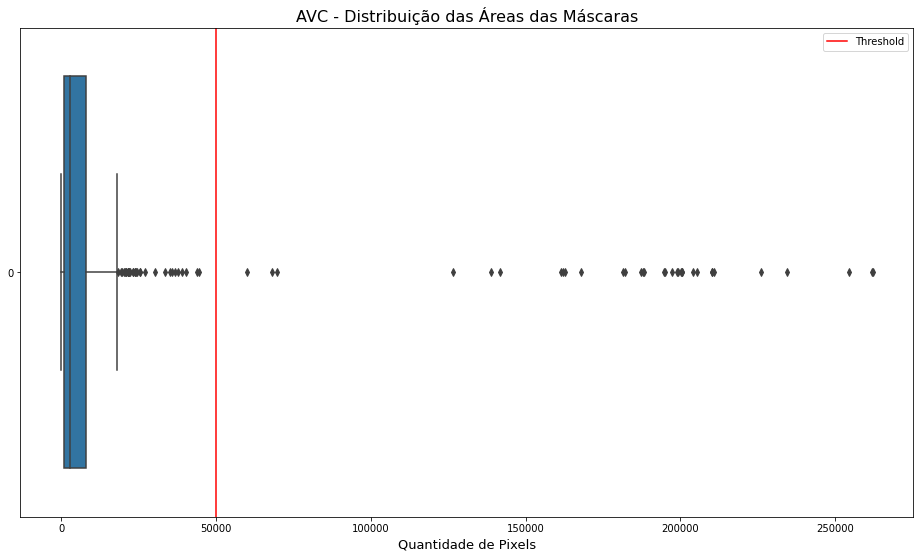

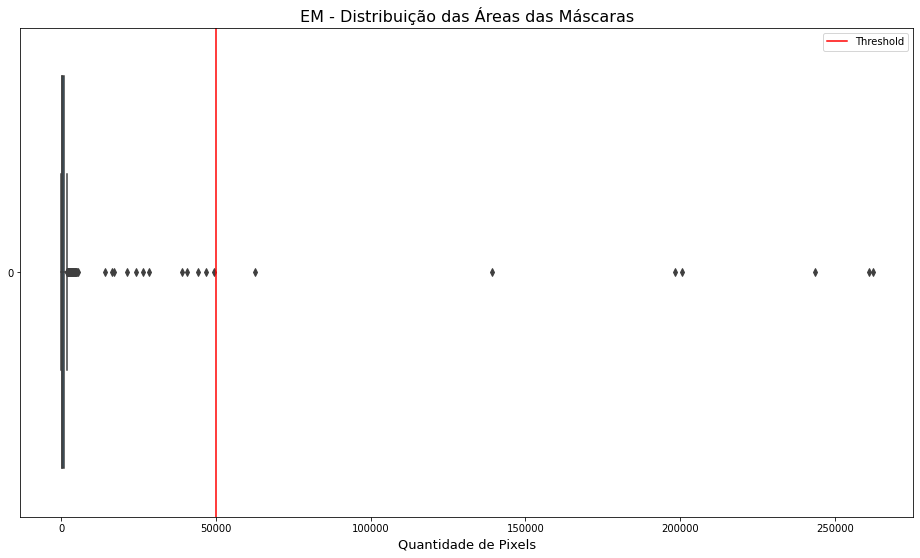

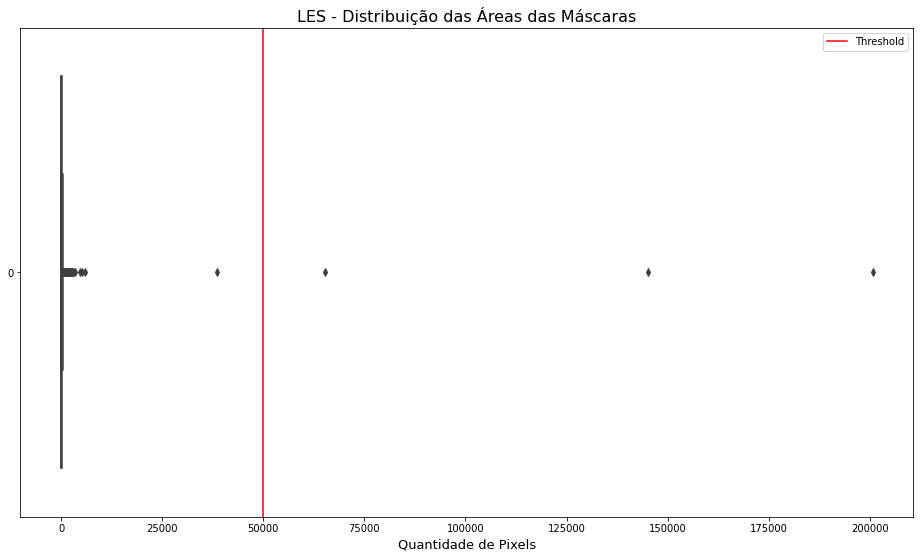

In [5]:
# Obter o conjunto disponível de mascaras
avc_mask_list = glob(PATH_TRAIN+'AVC/*_mask.png')
em_mask_list = glob(PATH_TRAIN+'EM/*_mask.png')
les_mask_list = glob(PATH_LES+'*_mask.png')
print("Num mask AVC: ", len(avc_mask_list))
print("Num mask EM: ", len(em_mask_list))
print("Num mask LES: ", len(les_mask_list))
print()

# Obtenção dos histogramas das máscaras
avc_mask_areas = get_mask_area(avc_mask_list)
em_mask_areas = get_mask_area(em_mask_list)
les_mask_areas = get_mask_area(les_mask_list)

threshold = 50_000 # limite do tamanho das máscaras (~25% da imagem)

# Obter indices das mascaras selecionadas
avc_indxs = get_mask_indxs(avc_mask_areas, threshold)
em_indxs = get_mask_indxs(em_mask_areas, threshold)
les_indxs = get_mask_indxs(les_mask_areas, threshold)

# Conjunto das máscaras selecionadas
avc_mask_set = list(map(lambda i: name_from_path(avc_mask_list[i]), avc_indxs))
em_mask_set = list(map(lambda i: name_from_path(em_mask_list[i]), em_indxs))
les_mask_set = list(map(lambda i: name_from_path(les_mask_list[i]), les_indxs))

# Ober todas as imagens disponíveis
avc_img_list = glob(PATH_TRAIN+'AVC/*[0-9].bmp')
avc_img_list += glob(PATH_TRAIN+'AVC/*[0-9].png')
em_img_list = glob(PATH_TRAIN+'EM/*[0-9].bmp')
em_img_list += glob(PATH_TRAIN+'EM/*[0-9].png')
les_img_list = glob(PATH_LES+'*[0-9].bmp')
les_img_list += glob(PATH_LES+'*[0-9].png')

# Lista de imagens que possuem máscaras sem extensões
avc_f_img_set = list(map(lambda i: mask_to_img(i), avc_mask_set))
em_f_img_set = list(map(lambda i: mask_to_img(i), em_mask_set))
les_f_img_set = list(map(lambda i: mask_to_img(i, True), les_mask_set))

# Obter a lista de imagens que possuem máscaras com suas extensões
avc_imgs = list(map(lambda img: name_from_path(img), avc_img_list))
avc_imgs = get_images(avc_imgs, avc_f_img_set)
em_imgs = list(map(lambda img: name_from_path(img), em_img_list))
em_imgs = get_images(em_imgs, em_f_img_set)
les_imgs = list(map(lambda img: name_from_path(img), les_img_list))
les_imgs = get_images(les_imgs, les_f_img_set)

print("Num mask Selecionadas AVC: ", len(avc_imgs))
print("Num mask Selecionadas EM: ", len(em_imgs))
print("Num mask Selecionadas LES: ", len(les_imgs))
print()


# Imprimir distribuição das areas das máscaras
x = 'Quantidade de Pixels' # xlabel dos gráficos

title = "AVC - Distribuição das Áreas das Máscaras"
fname = "boxplot_AVC"
boxplot_save(avc_mask_areas, dict(title=title, fname=fname, x=x), threshold)
print()

title = "EM - Distribuição das Áreas das Máscaras"
fname = "boxplot_EM"
boxplot_save(em_mask_areas, dict(title=title, fname=fname, x=x), threshold)
print()

title = "LES - Distribuição das Áreas das Máscaras"
fname = "boxplot_LES"
boxplot_save(les_mask_areas, dict(title=title, fname=fname, x=x), threshold)

# Obter a áreas das máscaras selecionadas
avc_mask_areas = list(map(lambda i: avc_mask_areas[i], avc_indxs))
em_mask_areas = list(map(lambda i: em_mask_areas[i], em_indxs))
les_mask_areas = list(map(lambda i: les_mask_areas[i], les_indxs))

# Criar DataFrame em que cada linha possui a imagem e sua máscara
avc_set_df = create_df(avc_imgs, avc_mask_set, avc_mask_areas) 
em_set_df = create_df(em_imgs, em_mask_set, em_mask_areas)
les_set_df = create_df(les_imgs, les_mask_set, les_mask_areas)

# Salvar dataFrames como CSV
avc_set_df.to_csv(PATH_DATA+"avc_set_df.csv", index=False)
em_set_df.to_csv(PATH_DATA+"em_set_df.csv", index=False)
les_set_df.to_csv(PATH_DATA+"les_set_df.csv", index=False)